In [1]:
from google.colab import files
from google.colab import drive
import os

In [2]:
drive.mount('/content/drive') # connect Google Drive
dataset_path = '/content/drive/My Drive/galaxies morph ds'
os.listdir(dataset_path)
!cp '/content/drive/My Drive/galaxies morph ds/archive (1).zip' /content/ # copy the ds to Colab env.

Mounted at /content/drive


Let's extract the dataset as zip file

In [3]:
import zipfile

# Unzip the file
with zipfile.ZipFile('/content/archive (1).zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')  # Extract to a folder named 'dataset'

# Check the contents of the unzipped folder
os.listdir('/content/dataset')

['train_label.csv', 'Train_images']

Let's read the csv file with the ground truth labels associated with each sample.

In [4]:
import pandas as pd

# Load the CSV file
csv_path = '/content/dataset/train_label.csv'  # Update path
df = pd.read_csv(csv_path, header = None, names=['galaxy_id', 'morph_label'])

# Inspect the CSV data
df.head()

,galaxy_id,morph_label
0,100053,Class1
1,100122,Class1
2,100143,Class3
3,100288,Class1
4,100295,Class1


In [29]:
# Create a dictionary that associate each folder name to an int label
folder_to_class = {
    'Cigar-shaped smooth': 0,
    'In between smooth': 1,
    'completely round smooth': 2,
    'edge-on': 3,
    'spiral': 4
}

class_names = {value: key for key, value in folder_to_class.items()}

In [6]:
dataset_path = "/content/dataset/Train_images/Train_images"

In order to avoid class imbalance and reduce the dataset size, we'll extract the minimum number of images between all the classes.

In [7]:
import os

img_counts = {}

for folder_name in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder_name)
    if os.path.isdir(folder_path):
      img_counts[folder_name] = len(os.listdir(folder_path))

min_images = min(img_counts.values())
print(f"Minimum number of images across all classes: {min_images}")

Minimum number of images across all classes: 579


The minimum number of images is 579, hence we'll extract 579 images from each folder to create our initial Tensorflow dataset.

We'll resize images from 424x424 to 224x224 because our aim is to recognize shapes, hence we are not interested in details. Given that, I can downsample the images without loosing crucial infos.

In [8]:
def to_one_hot(labels, num_classes):
    return tf.one_hot(labels, depth=num_classes)

num_classes = len(folder_to_class)

In [9]:
import tensorflow as tf
import random

img_height = 224
img_width = 224

# Function to create a dataset for a specific class
def create_class_dataset(class_path, class_label, min_images):
    # List all image filenames in the class directory
    all_images = os.listdir(class_path)

    # Randomly select a subset of images
    selected_images = random.sample(all_images, min_images)

    print(selected_images)

    # Generate full paths to the selected images
    image_paths = [os.path.join(class_path, img) for img in selected_images]

    # Create a list of labels for the selected images
    labels = [class_label] * len(image_paths)

    # Create a TensorFlow Dataset from the image paths and labels
    class_ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    return class_ds

# Initialize the balanced dataset
balanced_dataset = None

# Create the balanced dataset
for folder_name, class_label in folder_to_class.items():
    print(f"Creating dataset for class: {folder_name}")
    folder_path = os.path.join(dataset_path, folder_name)

    if os.path.isdir(folder_path):
        class_ds = create_class_dataset(folder_path, class_label, min_images)
        if balanced_dataset is None:
            balanced_dataset = class_ds
        else:
            balanced_dataset = balanced_dataset.concatenate(class_ds)

# Preprocess each image: resizing
def process_image(file_path, label):
    # Read the image file
    img = tf.io.read_file(file_path)

    # Decode the image
    img = tf.image.decode_image(img, channels=3)

    # Check if image tensor has an unknown shape
    img = tf.ensure_shape(img, [None, None, 3])

    # Resize the image to the target dimensions
    img = tf.image.resize(img, [img_height, img_width])

    # Normalize the image
    img = img / 255.0  # Normalize to [0,1] range

    # Convert label to one-hot encoding
    label = tf.one_hot(label, depth=num_classes)

    return img, label

# Apply the preprocessing function to the dataset
balanced_dataset = balanced_dataset.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)

Creating dataset for class: Cigar-shaped smooth
['437499.jpg', '602105.jpg', '324977.jpg', '669061.jpg', '176119.jpg', '427497.jpg', '594188.jpg', '768892.jpg', '171562.jpg', '565335.jpg', '967498.jpg', '958430.jpg', '119720.jpg', '946113.jpg', '405977.jpg', '729455.jpg', '600936.jpg', '898362.jpg', '341480.jpg', '141797.jpg', '509286.jpg', '188505.jpg', '914775.jpg', '610014.jpg', '312470.jpg', '567560.jpg', '488873.jpg', '762718.jpg', '124977.jpg', '377664.jpg', '742022.jpg', '285805.jpg', '401248.jpg', '139821.jpg', '907890.jpg', '147305.jpg', '771189.jpg', '195626.jpg', '399466.jpg', '200659.jpg', '150162.jpg', '391692.jpg', '570979.jpg', '734284.jpg', '997804.jpg', '706780.jpg', '981245.jpg', '368993.jpg', '987793.jpg', '449570.jpg', '432506.jpg', '227515.jpg', '727400.jpg', '334050.jpg', '469424.jpg', '402235.jpg', '416661.jpg', '762995.jpg', '588785.jpg', '762804.jpg', '610034.jpg', '217327.jpg', '129376.jpg', '758974.jpg', '527578.jpg', '162893.jpg', '611834.jpg', '946014.jpg',

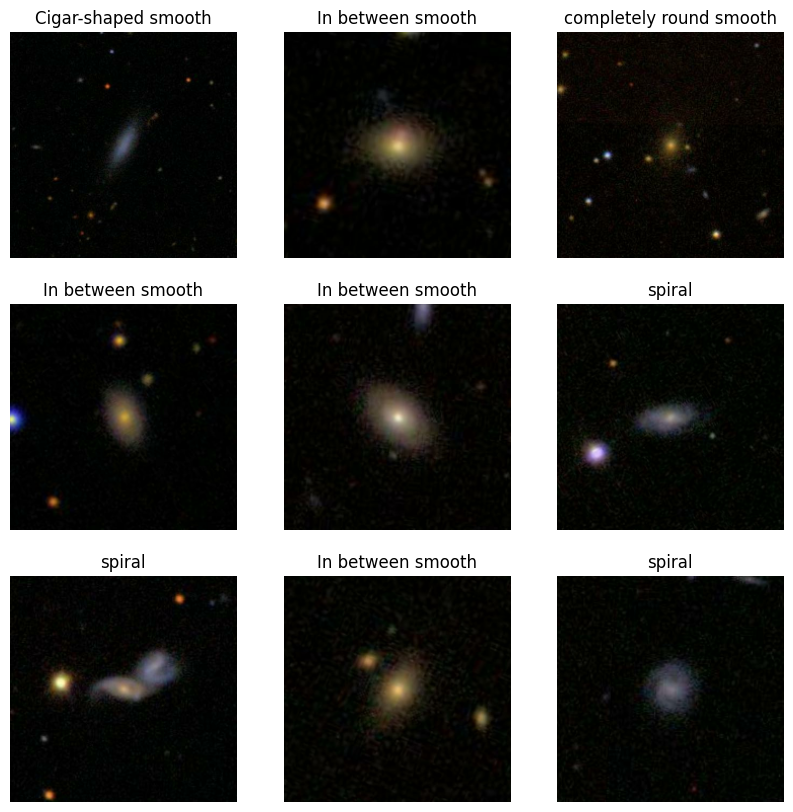

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def collect_data(dataset):
    images_list = []
    labels_list = []

    # Collect all images and labels from the dataset
    for image, label in dataset:
        images_list.append(image.numpy())
        labels_list.append(label.numpy())  # Assuming labels are byte strings

    return images_list, labels_list

def random_sample(images_list, labels_list, num_samples):
    indices = np.random.choice(len(images_list), num_samples, replace=False)
    sampled_images = [images_list[i] for i in indices]
    sampled_labels = [labels_list[i] for i in indices]

    return sampled_images, sampled_labels

def display_images(images, labels):
    plt.figure(figsize=(10, 10))
    for i in range(min(9, len(images))):  # Display up to 9 images
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        label_idx = np.argmax(labels[i]) # Convert to the index of the max value
        morph_class = class_names[label_idx]
        plt.title(morph_class)
        plt.axis('off')
    plt.show()

# Collect all images and labels from the dataset
images_list, labels_list = collect_data(balanced_dataset)

# Randomly sample 9 images and their labels
sampled_images, sampled_labels = random_sample(images_list, labels_list, num_samples=9)

# Display the sampled images and labels
display_images(sampled_images, sampled_labels)

Let's create now the training, the validation and the test set.

In [11]:
# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Define batch size
batch_size = 64

# Function to split the dataset
def split_dataset(dataset, train_ratio, val_ratio):
    dataset_size = len(dataset)
    train_size = int(dataset_size * train_ratio)
    val_size = int(dataset_size * val_ratio)

    # Create train, validation, and test splits
    dataset = dataset.shuffle(buffer_size=min_images * len(folder_to_class))  # Shuffle the dataset before splitting
    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size + val_size)

    return train_ds, val_ds, test_ds

# Split the dataset into training, validation, and test sets
train_ds, val_ds, test_ds = split_dataset(balanced_dataset, train_ratio, val_ratio)

# Apply batching and prefetching to the datasets
train_ds = train_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
def count_total_examples(dataset):
    total_count = 0
    for batch in dataset:
        images, _ = batch
        total_count += len(images)
    return total_count

# Verify dataset sizes
train_size = count_total_examples(train_ds)
val_size = count_total_examples(val_ds)
test_size = count_total_examples(test_ds)

print(f"Training dataset size: {train_size} examples")
print(f"Validation dataset size: {val_size} examples")
print(f"Test dataset size: {test_size} examples")

Training dataset size: 2026 examples
Validation dataset size: 434 examples
Test dataset size: 435 examples


In [13]:
for images, labels in train_ds.take(1):
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels shape: {labels.shape}")

Batch of images shape: (64, 224, 224, 3)
Batch of labels shape: (64, 5)


In [14]:
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

num_classes = len(folder_to_class)

model = Sequential([
    Input((224,224,3)),
    Conv2D(16, (3, 3), activation = "relu"),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation = "relu"),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation = "relu"),
    MaxPooling2D(2, 2),
    Flatten(),
    #Dropout(0.5),
    Dense(64, activation = "relu"),
    Dense(num_classes, activation = "softmax")
])

model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 43264)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,768,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,792,869 (10.65 MB)

 Trainable params: 2,792,869 (10.65 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 132s 4s/step - accuracy: 0.2799 - loss: 1.5621 - val_accuracy: 0.4885 - val_loss: 1.2998
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 131s 4s/step - accuracy: 0.5402 - loss: 1.1791 - val_accuracy: 0.6106 - val_loss: 0.9482
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.6833 - loss: 0.8493 - val_accuracy: 0.6590 - val_loss: 0.8849
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 118s 3s/step - accuracy: 0.7293 - loss: 0.6725 - val_accuracy: 0.7857 - val_loss: 0.5840
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 117s 4s/step - accuracy: 0.7776 - loss: 0.5852 - val_accuracy: 0.8502 - val_loss: 0.4013
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.8389 - loss: 0.4254 - val_accuracy: 0.8641 - val_loss: 0.3619
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - accuracy: 0.8864 - loss: 0.3206 - val_accuracy: 0.9009 - val_loss: 0.2786
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 119s 4s/step - accuracy: 0.9037 - loss: 0.2907 - val_accuracy: 0.9447 - v

In [20]:
# We can also use the history (that we saved before) to check the behavior of the training.
# history is a Python dictionary that cointains the values of the behavior of the loss
# during training (one value for each epoch).
def display_history(history):
    mse_training = history.history['loss']
    acc_training = history.history['accuracy']

    mse_val = history.history['val_loss']
    acc_val = history.history['val_accuracy']

    # Visualize the behavior of the loss
    plt.plot(mse_training)
    plt.plot(mse_val)
    plt.grid()
    plt.title('Loss during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

    # and of the accuracy
    plt.plot(acc_training)
    plt.plot(acc_val)
    plt.grid()
    plt.title('Accuracy during training')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

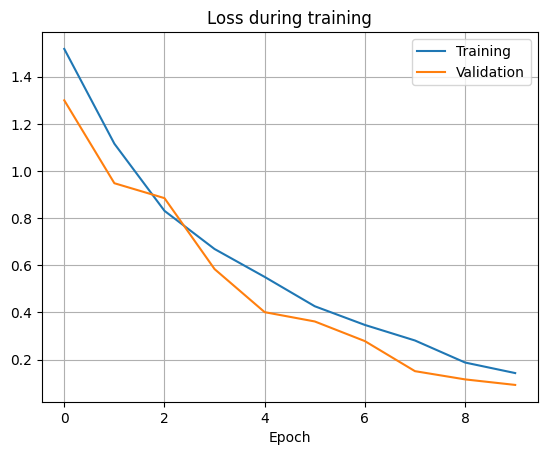

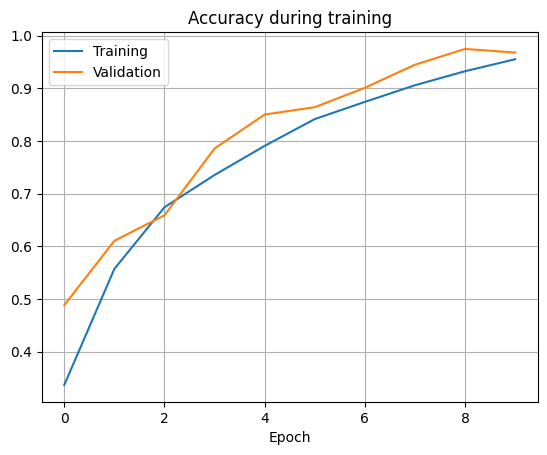

In [21]:
display_history(history)

In [23]:
y_test = []
y_pred = []

# Iterate through the batched test dataset
for images, labels in test_ds:
    # Append true labels
    y_test.append(labels.numpy())  # Convert to numpy array

    # Make predictions and append them
    preds = model.predict(images)
    y_pred.append(preds)

# Flatten the lists to get the complete arrays
y_test = np.concatenate(y_test)
y_pred = np.concatenate(y_pred)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 453ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 412ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 410ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 400ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 769ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step


In [24]:
# Convert predicted probabilities or one-hot encoded vectors to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert true labels
y_test_labels = np.argmax(y_test, axis=1)

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        95
           1       0.87      0.99      0.93        83
           2       1.00      0.97      0.98        87
           3       0.98      1.00      0.99        83
           4       0.99      0.94      0.96        87

    accuracy                           0.97       435
   macro avg       0.97      0.97      0.97       435
weighted avg       0.97      0.97      0.97       435



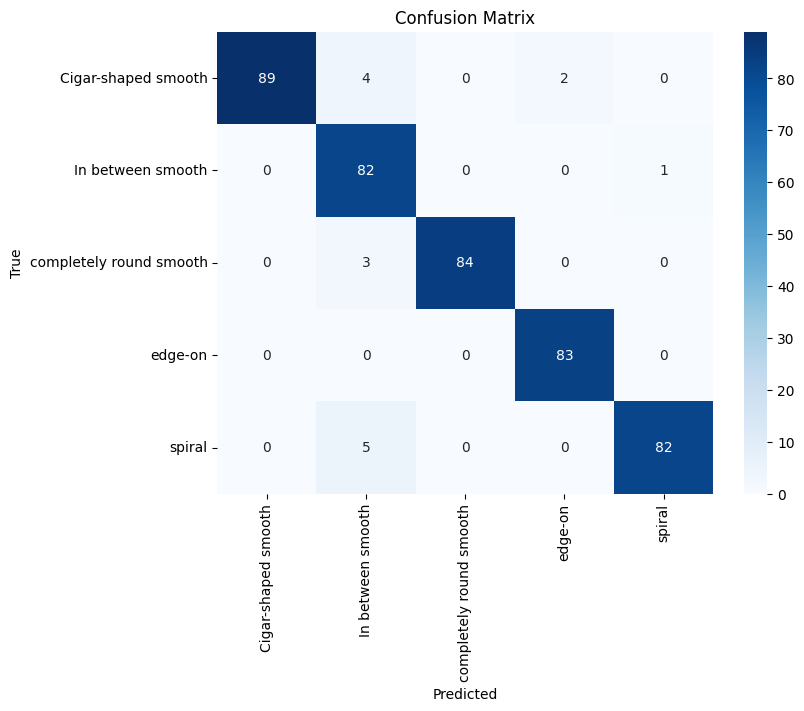

In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate the model
print(classification_report(y_test_labels, y_pred_labels))

# Plot the confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names.values(), yticklabels=class_names.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 396ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 416ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 408ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 412ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step


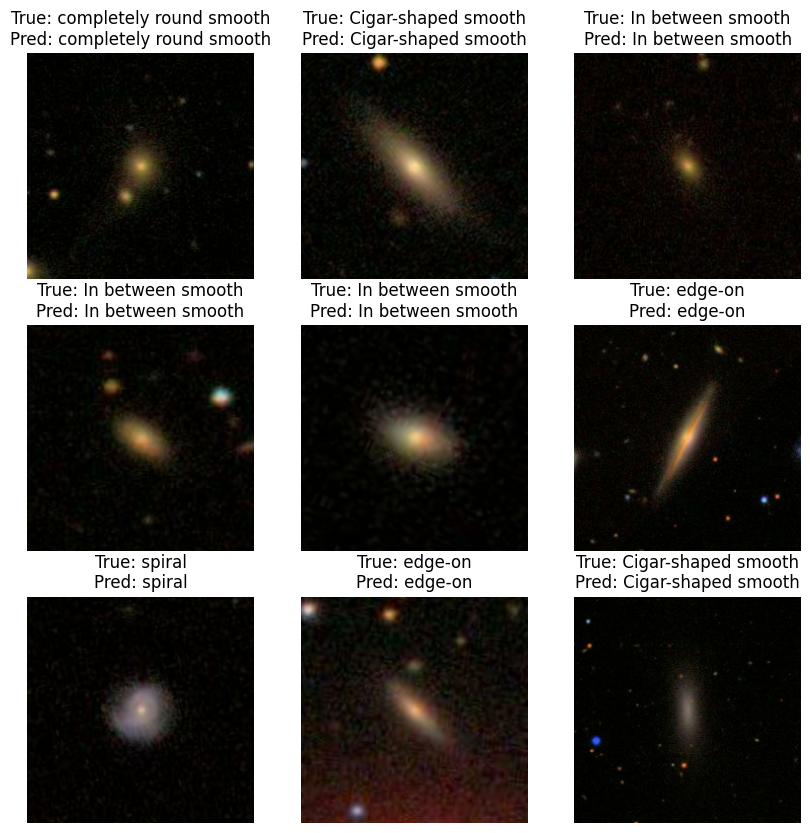

In [39]:
import matplotlib.pyplot as plt
import numpy as np

def collect_data_and_predictions(dataset, model):
    images_list = []
    true_labels_list = []
    pred_labels_list = []

    # Collect all images and labels from the dataset and make predictions
    for image_batch, true_label_batch in dataset:
        images_list.extend(image_batch.numpy())
        true_labels_list.extend(true_label_batch.numpy())

        # Make predictions
        pred_probs = model.predict(image_batch)
        pred_labels_list.extend(np.argmax(pred_probs, axis=1))  # Get predicted class indices

    return images_list, true_labels_list, pred_labels_list

def random_sample(images_list, true_labels_list, pred_labels_list, num_samples):
    indices = np.random.choice(len(images_list), num_samples, replace=False)
    sampled_images = [images_list[i] for i in indices]
    sampled_true_labels = [true_labels_list[i] for i in indices]
    sampled_pred_labels = [pred_labels_list[i] for i in indices]

    return sampled_images, sampled_true_labels, sampled_pred_labels

def display_images(images, true_labels, pred_labels, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(min(9, len(images))):  # Display up to 9 images
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        true_label_idx = np.argmax(true_labels[i])  # Convert to index if labels are one-hot encoded
        pred_label_idx = pred_labels[i]
        true_class = class_names[true_label_idx]
        pred_class = class_names[pred_label_idx]
        plt.title(f"True: {true_class}\nPred: {pred_class}")
        plt.axis('off')
    plt.show()

# Collect all images, true labels, and predictions from the dataset
images_list, true_labels_list, pred_labels_list = collect_data_and_predictions(test_ds, model)

# Randomly sample 9 images, true labels, and predictions
sampled_images, sampled_true_labels, sampled_pred_labels = random_sample(images_list, true_labels_list, pred_labels_list, num_samples=9)

# Display the sampled images with true labels and predictions
display_images(sampled_images, sampled_true_labels, sampled_pred_labels, class_names)